In [1]:
import pandas as pd
import re
from datetime import datetime as dt
import collections
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor  
from sklearn import metrics

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [3]:
# чтение и просмотр датасета
food = pd.read_csv('food.csv')
food.info()
display(food.head(7))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963
5,id_1418,Oporto,NaN,1419.0,3.0,NaN,2.0,"[['There are better 3 star hotel bars', 'Amazi...",/Restaurant_Review-g189180-d12503536-Reviews-D...,d12503536
6,id_1720,Milan,"['Italian', 'Pizza']",1722.0,4.0,$,50.0,"[['Excellent simple local eatery.', 'Excellent...",/Restaurant_Review-g187849-d5808504-Reviews-Pi...,d5808504


In [4]:
# переименование столбцов
food.columns = ['rest_id','city','cuisine','rank','rating',
                'prices','num_rev','reviews','ta_url','ta_id']

In [5]:
# функция выделения дат из отзывов
def dates(text):
    return re.findall(r'\d\d\/\d\d\/\d{4}', text)

# добавление столбца с датами отзывов
food['dates'] = food.reviews.apply(dates)

# удаление строк с пропусками дат (т.к. корректно заменить их нечем)
for i in list(food.index):
    if len(food.dates[i]) < 2:
        food = food.drop(i, axis=0)

In [7]:
# добавление двух столбцов с новыми признаками на основе дат

food['date_last'] = 0    # дата последнего отзыва
food['date_delta'] = 0    # промежуток между отзывами в днях

for i in list(food.index):
    food.date_last[i] = dt.date(max(pd.to_datetime(food.dates[i][0]),
                                    pd.to_datetime(food.dates[i][1])))
    food.date_delta[i] = (abs(pd.to_datetime(food.dates[i][0])-
                              pd.to_datetime(food.dates[i][1]))).days

In [8]:
# просмотр результата работы с датами
display(food.head(3))

,rest_id,city,cuisine,rank,rating,prices,num_rev,reviews,ta_url,ta_id,dates,date_last,date_delta
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,"[12/31/2017, 11/20/2017]",2017-12-31,41
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,"[07/06/2017, 06/19/2016]",2017-07-06,382
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,"[01/08/2018, 01/06/2018]",2018-01-08,2


In [9]:
# очистка столбца со стилями кухни от лишних символов
food.cuisine = food.cuisine.str.replace('[', '')
food.cuisine = food.cuisine.str.replace(']', '')
food.cuisine = food.cuisine.str.replace("'", '')

In [10]:
# определение полного списка стилей кухни
styles = food.cuisine.dropna()
styles = styles.str.split(', ').sum()

# общее количество стилей кухни
display(len(collections.Counter(styles).most_common()))

# сымые частые стили кухни
display(collections.Counter(styles).most_common(7))

125

[('Vegetarian Friendly', 10926),
 ('European', 9219),
 ('Mediterranean', 5685),
 ('Italian', 4824),
 ('Vegan Options', 4417),
 ('Gluten Free Options', 4065),
 ('Bar', 3072)]

In [11]:
# заполнение пропусков в стилях кухнях 
# наиболее логичным из самых частых значений
food.cuisine = food.cuisine.fillna('European')

# добавление столбца с новым признаком - количеством стилей кухни
food['num_cuisine'] = food.cuisine.apply(lambda x: len(x.split(', ')))

In [12]:
# просмотр результата работы со стилями кухни
display(food.head(3))

,rest_id,city,cuisine,rank,rating,prices,num_rev,reviews,ta_url,ta_id,dates,date_last,date_delta,num_cuisine
0,id_5569,Paris,"European, French, International",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,"[12/31/2017, 11/20/2017]",2017-12-31,41,3
1,id_1535,Stockholm,European,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,"[07/06/2017, 06/19/2016]",2017-07-06,382,1
2,id_352,London,"Japanese, Sushi, Asian, Grill, Vegetarian Frie...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,"[01/08/2018, 01/06/2018]",2018-01-08,2,7


In [13]:
# определение всех вариантов обозначения уровня цен
display(food.prices.value_counts())

$$ - $$$    16721
$            5287
$$$$         1289
Name: prices, dtype: int64

In [14]:
# замена значений столбца с уровнями цен на ординальные

for i in list(food.index):
    if food.prices[i] == '$':
        food.prices[i] = 1
    elif food.prices[i] == '$$ - $$$':
        food.prices[i] = 2
    elif food.prices[i] == '$$$$':
        food.prices[i] = 3

In [15]:
# заполнение пропусков в столбце с уровнями цен наиболее частым, т.е. средним
food.prices = food.prices.fillna(2)

In [16]:
# просмотр результата работы с уровнями цен
display(food.head(3))

,rest_id,city,cuisine,rank,rating,prices,num_rev,reviews,ta_url,ta_id,dates,date_last,date_delta,num_cuisine
0,id_5569,Paris,"European, French, International",5570.0,3.5,2,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,"[12/31/2017, 11/20/2017]",2017-12-31,41,3
1,id_1535,Stockholm,European,1537.0,4.0,2,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,"[07/06/2017, 06/19/2016]",2017-07-06,382,1
2,id_352,London,"Japanese, Sushi, Asian, Grill, Vegetarian Frie...",353.0,4.5,3,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,"[01/08/2018, 01/06/2018]",2018-01-08,2,7


In [17]:
# определение списка городов
display(food['city'].unique())

array(['Paris', 'Stockholm', 'London', 'Munich', 'Oporto', 'Milan',
       'Bratislava', 'Rome', 'Berlin', 'Dublin', 'Brussels', 'Zurich',
       'Copenhagen', 'Amsterdam', 'Hamburg', 'Barcelona', 'Budapest',
       'Oslo', 'Lisbon', 'Helsinki', 'Vienna', 'Edinburgh', 'Prague',
       'Madrid', 'Lyon', 'Geneva', 'Warsaw', 'Ljubljana', 'Luxembourg',
       'Athens', 'Krakow'], dtype=object)

In [18]:
# добавление нового признака, отражающего размер городов 
# (население в тыс.чел. на основе данных из внешних источников)

populations = {'Paris':2141, 'Stockholm':962, 'London':8788, 'Berlin':3601, 
               'Munich':1456, 'Oporto':238, 'Milan':1366, 'Bratislava':413, 
               'Vienna':1841, 'Rome':2873, 'Barcelona':1620, 'Madrid':3223, 
               'Dublin':553, 'Brussels':1199, 'Zurich':434, 'Warsaw':1758, 
               'Budapest':1750, 'Copenhagen':616, 'Amsterdam':860, 'Lyon':516, 
               'Hamburg':1831, 'Lisbon':507, 'Prague':1281, 'Oslo':673, 
               'Helsinki':643, 'Edinburgh':436, 'Geneva':196, 'Ljubljana':278, 
               'Athens':664, 'Luxembourg':122, 'Krakow':767}

food['city_pop'] = 0

for i in list(food.index):
    food.city_pop[i] = populations[food.city[i]]

display(food.head(3))

,rest_id,city,cuisine,rank,rating,prices,num_rev,reviews,ta_url,ta_id,dates,date_last,date_delta,num_cuisine,city_pop
0,id_5569,Paris,"European, French, International",5570.0,3.5,2,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,"[12/31/2017, 11/20/2017]",2017-12-31,41,3,2141
1,id_1535,Stockholm,European,1537.0,4.0,2,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,"[07/06/2017, 06/19/2016]",2017-07-06,382,1,962
2,id_352,London,"Japanese, Sushi, Asian, Grill, Vegetarian Frie...",353.0,4.5,3,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,"[01/08/2018, 01/06/2018]",2018-01-08,2,7,8788


In [19]:
# добавление dummy-признаков посредством разделения городов на регионы 

North = ['Stockholm','Edinburgh','Geneva','Copenhagen']
West = ['Paris','London','Berlin','Munich','Oporto','Milan','Rome','Barcelona',
'Madrid','Dublin','Brussels','Amsterdam','Lyon','Hamburg','Lisbon','Luxembourg',
'Zurich']
Balkan = ['Bratislava','Vienna','Warsaw','Budapest','Prague','Krakow','Athens',
'Ljubljana','Oslo','Helsinki']

food['north'] = 0
food['west'] = 0
food['balkan'] = 0


for i in list(food.index):
    if food.city[i] in North:
        food.north[i] = 1
    elif food.city[i] in Balkan:
        food.balkan[i] = 1
    else:
        food.west[i] = 1

display(food.head(3))

,rest_id,city,cuisine,rank,rating,prices,num_rev,reviews,ta_url,ta_id,dates,date_last,date_delta,num_cuisine,city_pop,north,west,balkan
0,id_5569,Paris,"European, French, International",5570.0,3.5,2,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,"[12/31/2017, 11/20/2017]",2017-12-31,41,3,2141,0,1,0
1,id_1535,Stockholm,European,1537.0,4.0,2,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,"[07/06/2017, 06/19/2016]",2017-07-06,382,1,962,1,0,0
2,id_352,London,"Japanese, Sushi, Asian, Grill, Vegetarian Frie...",353.0,4.5,3,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,"[01/08/2018, 01/06/2018]",2018-01-08,2,7,8788,0,1,0


In [ ]:
# Также была добавлена группа dummy-признаков посредством объединения 
# близких стилей кухни по основным направлениям, но их добавление
# практически не повлияло на MAE, поэтому они были удалены:

# veg = ['Vegetarian Friendly','Vegan Options']
# fit = ['Gluten Free Options','Healthy']
# sea = ['Mediterranean','Seafood']
# bar = ['Bar','Pub','Wine Bar']
# fast = ['Cafe','Fast Food','American']
# asia = ['Sushi','Japanese','Asian']

In [20]:
# создание копии датасета без лишних столбцов для обработки моделью
food_cl = food.drop(columns=['rest_id','city','cuisine','reviews',
                             'ta_url','ta_id','dates'])

# замена даты последнего отзыва на количество прошедших с него дней,
# чтобы в копии датасета остались только числа
for i in list(food_cl.index):
    food_cl.date_last[i] = (dt.date(pd.to_datetime('2020-11-04')) - 
                            food_cl.date_last[i]).days

In [21]:
# просмотр итоговых данных для модели
display(food_cl)

,rank,rating,prices,num_rev,date_last,date_delta,num_cuisine,city_pop,north,west,balkan
0,5570.0,3.5,2,194.0,1039,41,3,2141,0,1,0
1,1537.0,4.0,2,10.0,1217,382,1,962,1,0,0
2,353.0,4.5,3,688.0,1031,2,7,8788,0,1,0
4,621.0,4.0,2,84.0,1082,272,3,1456,0,1,0
5,1419.0,3.0,2,2.0,1145,108,1,238,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
39995,500.0,4.5,2,79.0,1054,34,4,1366,0,1,0
39996,6341.0,3.5,2,542.0,1049,9,5,2141,0,1,0
39997,1652.0,4.5,2,4.0,1462,3127,2,962,1,0,0
39998,641.0,4.0,2,70.0,1212,23,5,1758,0,0,1


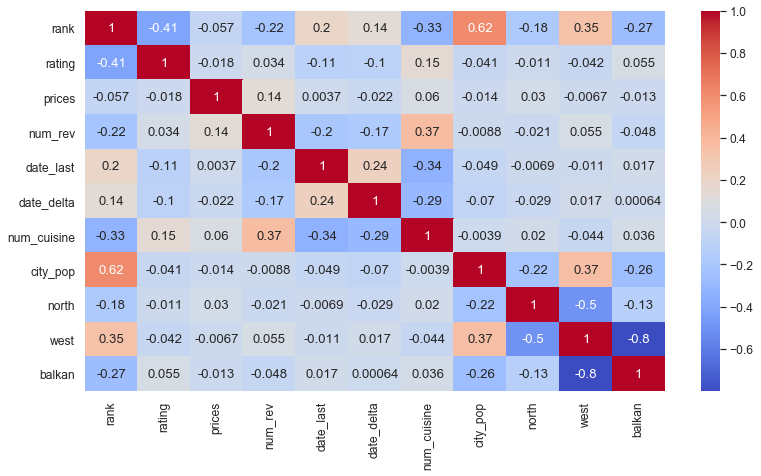

In [22]:
# просмотр графика корреляции итоговых признаков

plt.figure(figsize=(13, 7))
sns.set(font_scale=1.1)

food_cl.date_last = food_cl.date_last.apply(lambda x: int(x))
food_cl.date_delta = food_cl.date_delta.apply(lambda x: int(x))

correlation = food_cl.corr()

sns.heatmap(correlation, annot = True, cmap = 'coolwarm')

In [23]:
# разбивка датафрейма на части для обучения и тестирования модели  
# Х - данные с информацией, у - целевая переменная (рейтинги)  
X = food_cl.drop(['rating'], axis = 1)  
y = food_cl['rating']  
  
# загрузка инструмента для разбивки:  
from sklearn.model_selection import train_test_split  
  
# наборы данных с меткой "train" будут использоваться для обучения модели, 
# "test" - для тестирования.  
# Для тестирования будет использоваться 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [24]:
# создание модели
regr = RandomForestRegressor(n_estimators=100)  
  
# обучение модели на тестовом наборе данных  
regr.fit(X_train, y_train)
  
# применение обученной модели для предсказания рейтинга в тестовой выборке,
# предсказанные значения записываются в переменную y_pred  
y_pred = regr.predict(X_test)

In [25]:
# сравнение предсказанных значений (y_pred) с реальными (y_test);
# метрика Mean Absolute Error (MAE) показывает среднее отклонение 
# предсказанных значений от фактических
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.21842559359469907
